# 1. Logistic Regression
In this part, we are going to implement the logistic regression to classify admission given two feature.
## 1.1 Visualize the data
In this exercise, I want to use the `DataFrame.jl` to implement. We now can import the data as below.

In [1]:
using Gadfly
using DataFrames
using Optim

# Import data from txt file
df = readtable("data/ex2data1.txt", header = false, 
               names = [:exam1, :exam2, :admit], separator = ',')

INFO: Recompiling stale cache file /Users/JayWong/.julia/lib/v0.5/DataArrays.ji for module DataArrays.
INFO: Recompiling stale cache file /Users/JayWong/.julia/lib/v0.5/Gadfly.ji for module Gadfly.


,exam1,exam2,admit
1,34.62365962451697,78.0246928153624,0
2,30.28671076822607,43.89499752400101,0
3,35.84740876993872,72.90219802708364,0
4,60.18259938620976,86.30855209546826,1
5,79.0327360507101,75.3443764369103,1
6,45.08327747668339,56.3163717815305,0
7,61.10666453684766,96.51142588489624,1
8,75.02474556738889,46.55401354116538,1
9,76.09878670226257,87.42056971926803,1
10,84.43281996120035,43.53339331072109,1


To better visualize two different categories, we want to plot the data using two different color to represent `admitted` and `not admitted`. 

Now the Gadfly package can not change the color key legend generated by using `color` or `Scale.color_discrete_manual`, so we need to manually add an extra column to transfer numerical value to string representation(1 to "admitted" and 0 to "not admitted").

In [2]:
# Add one more column for the sake of plot
df[:admission] = map(df[:admit])do x
    if x == 1
        return "Admitted"
    else
        return "Not Admitted"
    end
end
df

,exam1,exam2,admit,admission
1,34.62365962451697,78.0246928153624,0,Not Admitted
2,30.28671076822607,43.89499752400101,0,Not Admitted
3,35.84740876993872,72.90219802708364,0,Not Admitted
4,60.18259938620976,86.30855209546826,1,Admitted
5,79.0327360507101,75.3443764369103,1,Admitted
6,45.08327747668339,56.3163717815305,0,Not Admitted
7,61.10666453684766,96.51142588489624,1,Admitted
8,75.02474556738889,46.55401354116538,1,Admitted
9,76.09878670226257,87.42056971926803,1,Admitted
10,84.43281996120035,43.53339331072109,1,Admitted


Then finally we can plot the data using Gadfly.

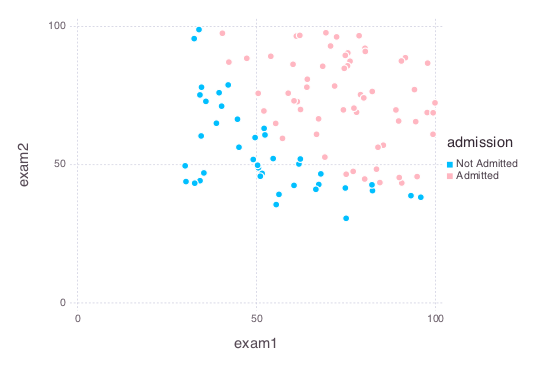

In [3]:
p = plot(df, x = :exam1, y = :exam2, color = :admission,
         Scale.color_discrete_manual(colorant"deep sky blue",
                                     colorant"light pink"))

## 1.2 Implementation
Then we would like to implement the following functions before minimizing the cost function:
1. model function
2. cost function
3. gradient function
4. format the data

### 1.2.1 Model function
The model function is givin as $$h(x) = \frac{1}{1 + e^{-(\Theta^T X)}}$$
The range is between $0$ and $1$, so we can think $h(x)$ as $\mathbb{P}(Y = 1 \mid X, \Theta)$.

In [4]:
# Define the logistic function, which supports both one-example-vector, or a
# training-set-matrix. x would be row vector here, and this function assumes 
# the first entry of the row is 1. If x is a training-set-matrix, then each 
# row is one example, and this function returns a n*1 matrix. If x is 
# one-example-vector, this function would return a Float rather than an array.
function h(Θ, x)
    if size(x, 1) == 1
        return 1 / (1 + e ^ -(x * Θ)[1])
    else
        return result = map(z -> 1 / (1 + e ^ z), -(x * Θ))
    end
end

h (generic function with 1 method)

### 1.2.2 Cost function
The cost function is used to represent the error term between our classification and the real data. 
We will use the following cost function.

$$
\text{cost}(h(x), y) = \Bigg\{
\begin{align*}
&  -\log(h(x)) \rightarrow \text{if } y = 1\\
& -\log(1 - h(x)) \rightarrow \text{if } y = 0\\
\end{align*}
$$

To make the implementation more convenient, we use algebra to transform the cost function into a one-line function.

$$\text{cost}(h(x), y) = -y \log(h(x)) - (1 - y)\log(1 - h(x))$$

Then the overall cost function would be as following:

$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y \log(h(x)) - (1 - y)\log(1 - h(x))]$$

If we implement it using vector, then it would be 

$$J(\Theta) = \frac{1}{m} \left(-y^{T}\log(h)-(1-y)^{T}\log(1-h)\right)$$

In [5]:
# Define the cost function.
function cost(Θ)
    hypo = h(Θ, feature)
    ((-value' * log(hypo) - (1 - value)' * log(1 - hypo)) / size(hypo, 1))[1]
end

cost (generic function with 1 method)

### 1.2.3 Gradient function
Next we want to get the partial derivative of $J(\theta)$ as the gradient function. This function is very useful for `Optim.jl` package to improve the performance and accuracy(In this exercise, we would not use gradient descent, but other more advanced algorithms, like BFGS).

$$
\begin{align*}
\frac{\partial}{\partial \theta_j}J(\theta) &= \frac{\partial}{\partial \theta_j}\frac{1}{m}\sum_{i=1}^{m}[-y \log(h(x)) - (1 - y)\log(1 - h(x))] \\
&= \frac{\partial}{\partial \theta_j}\frac{1}{m}\sum_{i=1}^{m}[-y \log(\frac{1}{1 + e^{-(\Theta^T X)}}) - (1 - y)\log(1 -\frac{1}{1 + e^{-(\Theta^T X)}})]\\
&=  \frac{1}{m}\sum_{i=1}^{m}(h(x) - y)x_j
\end{align*}
$$

This is exactly the same as the formula in the linear regression. If we use a vector implementation, then we will have the following:

$$ \frac{\partial}{\partial \theta_j}J(\theta)=  \frac{1}{m} X^{T} (h(X, \Theta) - Y)$$


In [6]:
# Define the gradient function for cost function
function g!(Θ, storage)
    result = (feature' * (h(Θ, feature) - value)) / size(feature, 1)
    for i in 1:length(result)
        storage[i] = result[i]
    end
end

g! (generic function with 1 method)

### 1.2.4 Data Format
Before doing the optimization to find the parameters minimizing the cost function, we want to manipulate the data format. In other words, we want to get the `feature` matrix and `value` matrix.

In [7]:
# Set up training sets
feature = ModelMatrix(ModelFrame(admit ~ exam1 + exam2, df)).m
value = convert(Array, df[:admit])

100-element Array{Int64,1}:
 0
 0
 0
 1
 1
 0
 1
 1
 1
 1
 0
 0
 1
 ⋮
 1
 0
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1

## 1.3 Optimizing

Then we can use `Optim.jl` package to minimizing the cost function. We need to provide the cost function, gradient function and starting parameters. Different packages requires different formats, the following is only for `Optim.jl`.

In [8]:
# Use Optim.jl to minimize the cost function 
res = optimize(cost, g!, [0.1, 0.1, 0.1])

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.1,0.1,0.1]
 * Minimizer: [-25.161333568401872,0.20623171331154289, ...]
 * Minimum: 2.034977e-01
 * Iterations: 12
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 53
 * Gradient Calls: 53

In [9]:
mini_Θ = Optim.minimizer(res)
mini_cost = Optim.minimum(res)

0.20349770158944003

## 1.4 Visualize the classification

Now we want to visualize the result we got above. Visualization is one straightforward way. From the plot of the sigmoid function, we know:

$$
\begin{align*}
\frac{1}{1 + e^{-z}} &\geqslant 0.5\\
z &\geqslant 0\\
\Theta^TX &\geqslant 0\\
\end{align*}
$$

- If $h(x) > 0.5$ (or $\Theta^TX \geqslant 0$), then we predict $Y = 1$.
- If $h(x) < 0.5$ (or $\Theta^TX \leqslant 0$), then we predict $Y = 0$.
- Setting $\Theta^TX = 0$, we can get a line, a plane or other stuff. We call it **Decision Boundary**.

Then we want to plot the decision boundary along with the raw training sets.

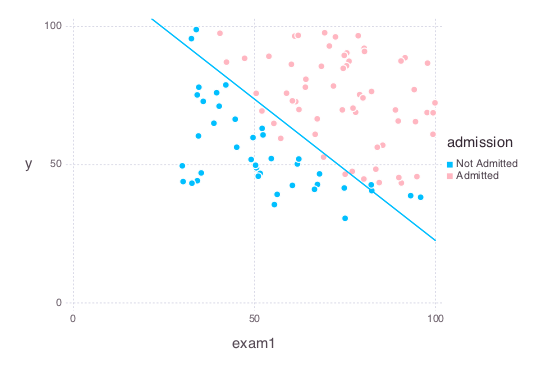

In [10]:
# Plot the points with the decision boundary
decision(x) = (mini_Θ[1] + mini_Θ[2] * x) / -mini_Θ[3]
l1 = layer(decision, 0, 100, Geom.line)
l2 = layer(df, x = :exam1, y = :exam2, color = :admission, Geom.point)
p2 = plot(l1, l2, Scale.color_discrete_manual(colorant"deep sky blue",
                                              colorant"light pink"),
          Coord.cartesian(xmin = 0, xmax = 100, ymin = 0, ymax = 100))

## 1.5 Making prediction

We want to use the classification directly without running the whole training process again in practical use.

In [11]:
# Function to predict the probability of admission
prob(exam1, exam2) = h(mini_Θ, [1 exam1 exam2])

# Test
println(prob(0, 0))
println(prob(50, 50))
println(prob(100, 100))

1.1818753475779378e-11
0.008357793712601688
0.9999998336210757


# 2 Regularized logistic regression

Now we want to try the regularization technique with logistic regression.

## 2.1 Visualizing the data
Same as the part1, we want to visualize the data to see the general distribution of dots. We first import the data using `Dataframe,jl` package.

In [1]:
workspace()
using Gadfly
using DataFrames
using Optim

λ = 1

# Import data
df = readtable("data/ex2data2.txt", separator = ',', header = false,
               names = [:test1, :test2, :res])

INFO: Recompiling stale cache file /Users/JayWong/.julia/lib/v0.5/Showoff.ji for module Showoff.
INFO: Recompiling stale cache file /Users/JayWong/.julia/lib/v0.5/Gadfly.ji for module Gadfly.


,test1,test2,res
1,0.051267,0.69956,1
2,-0.092742,0.68494,1
3,-0.21371,0.69225,1
4,-0.375,0.50219,1
5,-0.51325,0.46564,1
6,-0.52477,0.2098,1
7,-0.39804,0.034357,1
8,-0.30588,-0.19225,1
9,0.016705,-0.40424,1
10,0.13191,-0.51389,1


In [2]:
# Add one label column
df[:result] = map(df[:res]) do x
    if x == 1
        return "accepted"
    else
        return "rejected"
    end
end

118-element DataArrays.DataArray{Any,1}:
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 "accepted"
 ⋮         
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"
 "rejected"

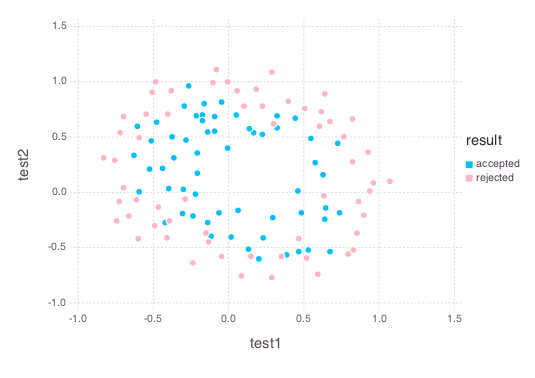

In [3]:
# Visualizing the data
p3 = plot(df, x = :test1, y = :test2, color = :result,  
          Scale.color_discrete_manual(colorant"deep sky blue",
                                      colorant"light pink"))

## 2.2 Implementation
Then we would like to implement the following functions before minimizing the cost function (same as part 1):
1. model function
2. cost function with regularization 
3. gradient function with regularization
4. feature mapping

### 2.2.1 Model function
The model function is givin as $$h(x) = \frac{1}{1 + e^{-(\Theta^T X)}}$$ 

It is the same as the logistic regression without regularization.

In [4]:
# Define the logistic function, which supports both one-example-vector, or a
# training-set-matrix. x would be row vector here, and this function assumes 
# the first entry of the row is 1. If x is a training-set-matrix, then each 
# row is one example, and this function returns a n*1 matrix. If x is 
# one-example-vector, this function would return a Float rather than an array.
function h(Θ, x)
    if size(x, 1) == 1
        return 1 / (1 + e ^ -(x * Θ)[1])
    else
        return result = map(z -> 1 / (1 + e ^ z), -(x * Θ))
    end
end

h (generic function with 1 method)

### 2.2.2 Cost function

We want to add a regularization term into the original logistic regression cost function. So the new general cost function is like **($\theta_0$ should not be regulated)**:


$$J(\Theta) = \frac{1}{2m}(\sum_{i=1}^{m}[\text{error}] + \lambda\sum_{i = 1}^{n}\theta_i^2)$$

For logistic regression, we have:

$$J(\theta) = - \frac{1}{m} \sum_{i=1}^m \large[ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))\large] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2$$

If we use vector form, then we will get:

$$J(\Theta) = \frac{1}{m} \left(-y^{T}\log(h)-(1-y)^{T}\log(1-h)\right) + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2$$

In [5]:
# Define the cost function. Regularization is used here. 
function cost(Θ)
    m = size(feature, 1)
    hypo = h(Θ, feature)
    pre = ((-value' * log(hypo) - (1 - value)' * log(1 - hypo)) / m)[1]
    # We do not regularize the first θ
    return pre + ((λ / (2 * m)) * sum(Θ[2:end] .^ 2))
end    

cost (generic function with 1 method)

### 2.2.3 Gradient function
For linear regression and logistic regression, if we take the partial dirivitive of $\theta_j$, then we would get:

$$
\begin{align}
\frac{\partial}{\partial \theta_j}J(\Theta) &= \frac{\partial}{\partial \theta_j}\frac{1}{2m}(\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y_i)^2 + \lambda\sum_{i = 1}^{n}\theta_i^2)\\ 
&= \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)})- y_i)\cdot x_j + \frac{\lambda}{m}\theta_j\\ 
\end{align}
$$

If we use a vector implementation, then we have **($\theta_0$ should not be regulated)**:

$$ \frac{\partial}{\partial \theta_j}J(\theta)=  \frac{1}{m} X^{T} (h(X, \Theta) - Y) + \sum_{j=1}^{m}\frac{\lambda}{m}\theta_j$$



In [6]:
# Define the gradient function for cost function. Regularization is used.
function g!(Θ, storage)
    m =  size(feature, 1)
    hypo = h(Θ, feature)
    result = (feature' * (hypo - value)) / m
    # No regularization for Θ[1]
    storage[:] = result + (λ / m) * [0; Θ[2:end]]
end

g! (generic function with 1 method)

### 2.2.4 Feature mapping
It is different from 1.2.4. In this case, we would do a more complicated data formatting. To classify a non-linear shape distributed data, we want more features. One natural way is to use higher degree of the feature. In this problem, we want to use all degrees up to 6.

$$
\text{feature_map}(\begin{bmatrix}x_1\\ x_2 \end{bmatrix}) = \begin{bmatrix}1 \\ x_1\\ x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ \vdots \\ \\x_1x_2^5 \\ x_2^6\end{bmatrix}
$$

In other words, we want a map $\mathbb{R}^2 \rightarrow \mathbb{R}^{28}$. After mapping, we would get a $n\times 28$ matrix to represent the features.

In [7]:
# Construct feature matrix
function get_new_row(x1, x2)
    new_row = [1]
    for i in 1:6
        for j in 0:i
            new_row = hcat(new_row, [x1^(i-j) * x2^j])
        end
    end
    return new_row
end

# Since Julia cannot delete row from a matrix, we cant use one dummy row.
# To use `vcat` we need to build a real first row first.
feature = get_new_row(df[:test1][1], df[:test2][1])

# Concatenate new row to the feature matrix
for r in 2:size(df, 1)
    x1 = df[:test1][r]
    x2 = df[:test2][r]
    feature = vcat(feature, get_new_row(x1, x2))
end

feature

118×28 Array{Float64,2}:
 1.0   0.051267    0.69956   0.00262831   …   0.0085894    0.117206   
 1.0  -0.092742    0.68494   0.00860108      -0.013981     0.103256   
 1.0  -0.21371     0.69225   0.045672        -0.0339735    0.110047   
 1.0  -0.375       0.50219   0.140625        -0.0119776    0.0160401  
 1.0  -0.51325     0.46564   0.263426        -0.0112352    0.010193   
 1.0  -0.52477     0.2098    0.275384     …  -0.000213303  8.52772e-5 
 1.0  -0.39804     0.034357  0.158436        -1.90547e-8   1.64472e-9 
 1.0  -0.30588    -0.19225   0.0935626        8.03309e-5   5.04892e-5 
 1.0   0.016705   -0.40424   0.000279057     -0.00018032   0.00436351 
 1.0   0.13191    -0.51389   0.0174002       -0.00472747   0.0184171  
 1.0   0.38537    -0.56506   0.14851      …  -0.0221999    0.0325512  
 1.0   0.52938    -0.5212    0.280243        -0.0203606    0.0200459  
 1.0   0.63882    -0.24342   0.408091        -0.000545959  0.000208036
 ⋮                                        ⋱         

In [8]:
# Construct value matrix
value = convert(Array, df[:res])

118-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

## 2.3 Optimizing

Eventually, we can use `Optim.jl` to find the optimal parameter $\Theta$. In this exercise, I set the global variable $\lambda$ (regularization parameter) $= 1$. 

In [9]:
# Find parameters Θ minimizing the cost function
res = optimize(cost, g!, repeat([0.5], inner = size(feature, 2)))

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.5,0.5, ...]
 * Minimizer: [1.2727395944246653,0.6252717156292734, ...]
 * Minimum: 5.290027e-01
 * Iterations: 26
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 102
 * Gradient Calls: 102

In [10]:
mini_Θ = Optim.minimizer(res)
mini_cost = Optim.minimum(res)

0.5290027297126544

## 2.4  Visualize the classification

Same as [part 1.4](#1.4-Visualize-the-classification), we want to plot the decision boundary to evaluate the result of logistic regression. Since the function is not linear anymore, we would want to use the `Geom.contour` in `Gadfly.jl`. We first need to explicitly define the feature mapping.

In [11]:
# Plot the decision boundary
function decision(x1::Float64, x2::Float64, a::Array{Float64})
    dot(a, [1, x1^1*x2^0, x1^0*x2^1, x1^2*x2^0, x1^1*x2^1, x1^0*x2^2, 
            x1^3*x2^0, x1^2*x2^1, x1^1*x2^2, x1^0*x2^3, x1^4*x2^0, x1^3*x2^1,
            x1^2*x2^2, x1^1*x2^3, x1^0*x2^4, x1^5*x2^0, x1^4*x2^1, x1^3*x2^2,
            x1^2*x2^3, x1^1*x2^4, x1^0*x2^5, x1^6*x2^0, x1^5*x2^1, x1^4*x2^2, 
            x1^3*x2^3, x1^2*x2^4, x1^1*x2^5, x1^0*x2^6])
end

decision (generic function with 1 method)

Then we can plot the training sets along with the decision boundary.

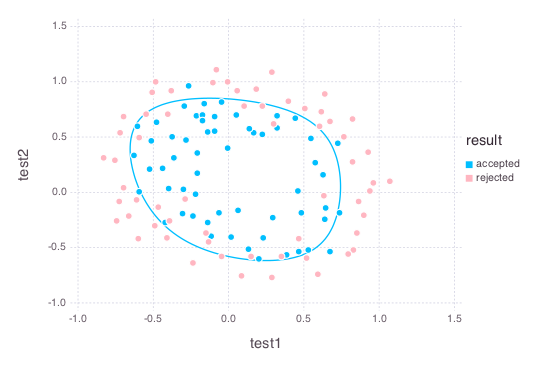

In [12]:
l1 = layer(df, x = :test1, y = :test2, color = :result, Geom.point)
l2 = layer(z = (x1,x2) -> decision(x1, x2, mini_Θ), 
           x = linspace(-1.0, 1.5, 100),
           y = linspace(-1.0, 1.5, 100),
           Geom.contour(levels = [0.0]),
           Theme(line_width = 1pt))

coord = Coord.cartesian(xmin=-1.0, xmax=1.5, ymin=-1.0, ymax=1.5)

p4 = plot(l1, l2, coord, Scale.color_discrete_manual(colorant"deep sky blue",
                                                     colorant"light pink"))

## 2.5 Making prediction
We want to use the classification directly without running the whole training process again in practical use.

In [13]:
# Function to predict the probability of being accepted
prob(test1, test2) = h(mini_Θ, get_new_row(test1, test2))

prob (generic function with 1 method)

In [14]:
# Tests
println(prob(0.0, 0.0))
println(prob(-0.5, -0.5))
println(prob(0.8, 0.5))

0.7812113605872674
0.30050238278229
0.246133858095978


# 3 Regularization parameter experiment
In this section, we want to try multiple values of $\lambda$ to see how it impacts on the result of our classification.

Before starting the learning process, we want to re-define the cost and gradient function where $\lambda$ is an argument for those functions.

In [15]:
# Plot multiple graphs using different λ
# Return cost and gradient function based on the given λ
function cost_and_gradient(Θ, λ)
    m = size(feature, 1)
    return (Θ::Array) -> begin
        hypo = h(Θ, feature)
        pre = ((-value' * log(hypo) - (1 - value)' * log(1 - hypo)) / m)[1]
        return pre + ((λ / (2 * m)) * sum(Θ[2:end] .^ 2))
    end, (Θ::Array, storage::Array) -> begin
        hypo = h(Θ, feature)
        result = (feature' * (hypo - value)) / m
        storage[:] = result + (λ / m) * [0; Θ[2:end]]
    end
end

cost_and_gradient (generic function with 1 method)

In [16]:
# Iterate within different λ
function multiple_λ(λ_candidates)
    for my_λ in λ_candidates
        cost1, g1! = cost_and_gradient(zeros(28, 1), my_λ)

        # Find the parameters
        res = optimize(cost1, g1!, repeat([0.5], inner = size(feature, 2)))
        mini_Θ = Optim.minimizer(res)
        
        # Plot the decision boundaries
        l2 = layer(z = (x1,x2) -> decision(x1, x2, mini_Θ), 
                   x = linspace(-1.0, 1.5, 1000),
                   y = linspace(-1.0, 1.5, 1000),
                   Geom.contour(levels = [0.0]),
                   Theme(line_width = 1pt))

        p5 = plot(l1, l2, coord, 
                  Scale.color_discrete_manual(colorant"deep sky blue",
                                              colorant"light pink"),
                  Guide.title("Regularization with λ = $(my_λ)"))

        display(p5)
    end
end

multiple_λ (generic function with 1 method)

Finally we can plot decision boundaries with different $\lambda$ values, and compare the results.

In [17]:
multiple_λ([1, 1, 1, 10, 10])

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 test1 
 
 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 -3.5 
 -3.4 
 -3.3 
 -3.2 
 -3.1 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 -4 
 -2 
 0 
 2 
 4 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 
 
 
 accepted 
 rejected 
 
 
 
 
 
 
 result 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M67.04,69.7 L 66.94 69.7 66.92 69.7 66.84 69.69 66.74 69.68 66.64 69.67 66.54 69.67 66.44 69.66 66.34 69.65 66.24 69.64 66.14 69.63 66.08 69.63 66.04 69.62 65.94 69.62 65.85 69.61 65.75 69.6 65.65 69.59 65.55 69.58 65.45 69.57 65.37 69.56 65.35 69.56 65.25 69.55 65.15 69.54 65.05 69.53 64.95 69.52 64.85 69.51 64.75 69.49 64.74 69.49 64.65 69.48 64.55 69.47 64.45 69.46 64.35 69.45 64.25 69.44 64.17 69.43 64.15 69.42 64.05 69.41 63.95 69.4 63.85 69.39 63.75 69.37 63.65 69.36 63.65 69.36 63.56 69.35 63.46 69.33 63.36 69.32 63.26 69.3 63.16 69.29 63.16 69.29 63.06 69.28 62.96 69.26 62.86 69.25 62.76 69.23 62.7 69.22 62.66 69.22 62.56 69.2 62.46 69.19 62.36 69.17 62.27 69.16 62.26 69.16 62.16 69.14 62.06 69.12 61.96 69.11 61.86 69.09 61.85 69.09 61.76 69.07 61.66 69.06 61.56 69.04 61.46 69.02 61.46 69.02 61.37 69 61.27 68.99 61.17 68.97 61.08 68.95 61.07 68.95 60.97 68.93 60.87 68.91 60.77 68.9 60.72 68.89 60.67 68.88 60.57 68.86 60.47 68.84 60.37 68.82 60.37 68.82 60.27 68.8 60.17 68.78 60.07 68.76 60.03 68.75 59.97 68.74 59.87 68.72 59.77 68.7 59.71 68.68 59.67 68.68 59.57 68.66 59.47 68.64 59.39 68.62 59.37 68.61 59.27 68.59 59.17 68.57 59.08 68.55 59.08 68.55 58.98 68.53 58.88 68.5 58.78 68.48 58.78 68.48 58.68 68.46 58.58 68.43 58.49 68.41 58.48 68.41 58.38 68.39 58.28 68.36 58.21 68.35 58.18 68.34 58.08 68.32 57.98 68.29 57.93 68.28 57.88 68.27 57.78 68.24 57.68 68.22 57.66 68.21 57.58 68.19 57.48 68.17 57.4 68.15 57.38 68.14 57.28 68.11 57.18 68.09 57.14 68.08 57.08 68.06 56.98 68.03 56.89 68.01 56.88 68.01 56.79 67.98 56.69 67.95 56.65 67.94 56.59 67.93 56.49 67.9 56.41 67.88 56.39 67.87 56.29 67.84 56.19 67.81 56.17 67.81 56.09 67.78 55.99 67.76 55.94 67.74 55.89 67.73 55.79 67.7 55.71 67.67 55.69 67.67 55.59 67.64 55.49 67.61 55.49 67.61 55.39 67.58 55.29 67.55 55.27 67.54 55.19 67.51 55.09 67.48 55.06 67.47 54.99 67.45 54.89 67.42 54.84 67.4 54.79 67.39 54.69 67.36 54.64 67.34 54.59 67.32 54.5 67.29 54.43 67.27 54.4 67.26 54.3 67.22 54.23 67.2 54.2 67.19 54.1 67.16 54.04 67.13 54 67.12 53.9 67.09 53.84 67.07 53.8 67.05 53.7 67.02 53.65 67 53.6 66.98 53.5 66.95 53.46 66.93 53.4 66.91 53.3 66.87 53.28 66.86 53.2 66.84 53.1 66.8 53.1 66.8 53 66.76 52.92 66.73 52.9 66.72 52.8 66.69 52.74 66.66 52.7 66.65 52.6 66.61 52.56 66.6 52.5 66.57 52.4 66.53 52.39 66.53 52.3 66.49 52.22 66.46 52.21 66.45 52.11 66.41 52.05 66.39 52.01 66.37 51.91 66.33 51.89 66.33 51.81 66.29 51.7

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 test1 
 
 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 -3.5 
 -3.4 
 -3.3 
 -3.2 
 -3.1 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 -4 
 -2 
 0 
 2 
 4 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 
 
 
 accepted 
 rejected 
 
 
 
 
 
 
 result 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M67.04,69.7 L 66.94 69.7 66.92 69.7 66.84 69.69 66.74 69.68 66.64 69.67 66.54 69.67 66.44 69.66 66.34 69.65 66.24 69.64 66.14 69.63 66.08 69.63 66.04 69.62 65.94 69.62 65.85 69.61 65.75 69.6 65.65 69.59 65.55 69.58 65.45 69.57 65.37 69.56 65.35 69.56 65.25 69.55 65.15 69.54 65.05 69.53 64.95 69.52 64.85 69.51 64.75 69.49 64.74 69.49 64.65 69.48 64.55 69.47 64.45 69.46 64.35 69.45 64.25 69.44 64.17 69.43 64.15 69.42 64.05 69.41 63.95 69.4 63.85 69.39 63.75 69.37 63.65 69.36 63.65 69.36 63.56 69.35 63.46 69.33 63.36 69.32 63.26 69.3 63.16 69.29 63.16 69.29 63.06 69.28 62.96 69.26 62.86 69.25 62.76 69.23 62.7 69.22 62.66 69.22 62.56 69.2 62.46 69.19 62.36 69.17 62.27 69.16 62.26 69.16 62.16 69.14 62.06 69.12 61.96 69.11 61.86 69.09 61.85 69.09 61.76 69.07 61.66 69.06 61.56 69.04 61.46 69.02 61.46 69.02 61.37 69 61.27 68.99 61.17 68.97 61.08 68.95 61.07 68.95 60.97 68.93 60.87 68.91 60.77 68.9 60.72 68.89 60.67 68.88 60.57 68.86 60.47 68.84 60.37 68.82 60.37 68.82 60.27 68.8 60.17 68.78 60.07 68.76 60.03 68.75 59.97 68.74 59.87 68.72 59.77 68.7 59.71 68.68 59.67 68.68 59.57 68.66 59.47 68.64 59.39 68.62 59.37 68.61 59.27 68.59 59.17 68.57 59.08 68.55 59.08 68.55 58.98 68.53 58.88 68.5 58.78 68.48 58.78 68.48 58.68 68.46 58.58 68.43 58.49 68.41 58.48 68.41 58.38 68.39 58.28 68.36 58.21 68.35 58.18 68.34 58.08 68.32 57.98 68.29 57.93 68.28 57.88 68.27 57.78 68.24 57.68 68.22 57.66 68.21 57.58 68.19 57.48 68.17 57.4 68.15 57.38 68.14 57.28 68.11 57.18 68.09 57.14 68.08 57.08 68.06 56.98 68.03 56.89 68.01 56.88 68.01 56.79 67.98 56.69 67.95 56.65 67.94 56.59 67.93 56.49 67.9 56.41 67.88 56.39 67.87 56.29 67.84 56.19 67.81 56.17 67.81 56.09 67.78 55.99 67.76 55.94 67.74 55.89 67.73 55.79 67.7 55.71 67.67 55.69 67.67 55.59 67.64 55.49 67.61 55.49 67.61 55.39 67.58 55.29 67.55 55.27 67.54 55.19 67.51 55.09 67.48 55.06 67.47 54.99 67.45 54.89 67.42 54.84 67.4 54.79 67.39 54.69 67.36 54.64 67.34 54.59 67.32 54.5 67.29 54.43 67.27 54.4 67.26 54.3 67.22 54.23 67.2 54.2 67.19 54.1 67.16 54.04 67.13 54 67.12 53.9 67.09 53.84 67.07 53.8 67.05 53.7 67.02 53.65 67 53.6 66.98 53.5 66.95 53.46 66.93 53.4 66.91 53.3 66.87 53.28 66.86 53.2 66.84 53.1 66.8 53.1 66.8 53 66.76 52.92 66.73 52.9 66.72 52.8 66.69 52.74 66.66 52.7 66.65 52.6 66.61 52.56 66.6 52.5 66.57 52.4 66.53 52.39 66.53 52.3 66.49 52.22 66.46 52.21 66.45 52.11 66.41 52.05 66.39 52.01 66.37 51.91 66.33 51.89 66.33 51.81 66.29 51.7

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 test1 
 
 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 -3.5 
 -3.4 
 -3.3 
 -3.2 
 -3.1 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 -4 
 -2 
 0 
 2 
 4 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 
 
 
 accepted 
 rejected 
 
 
 
 
 
 
 result 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M67.04,69.7 L 66.94 69.7 66.92 69.7 66.84 69.69 66.74 69.68 66.64 69.67 66.54 69.67 66.44 69.66 66.34 69.65 66.24 69.64 66.14 69.63 66.08 69.63 66.04 69.62 65.94 69.62 65.85 69.61 65.75 69.6 65.65 69.59 65.55 69.58 65.45 69.57 65.37 69.56 65.35 69.56 65.25 69.55 65.15 69.54 65.05 69.53 64.95 69.52 64.85 69.51 64.75 69.49 64.74 69.49 64.65 69.48 64.55 69.47 64.45 69.46 64.35 69.45 64.25 69.44 64.17 69.43 64.15 69.42 64.05 69.41 63.95 69.4 63.85 69.39 63.75 69.37 63.65 69.36 63.65 69.36 63.56 69.35 63.46 69.33 63.36 69.32 63.26 69.3 63.16 69.29 63.16 69.29 63.06 69.28 62.96 69.26 62.86 69.25 62.76 69.23 62.7 69.22 62.66 69.22 62.56 69.2 62.46 69.19 62.36 69.17 62.27 69.16 62.26 69.16 62.16 69.14 62.06 69.12 61.96 69.11 61.86 69.09 61.85 69.09 61.76 69.07 61.66 69.06 61.56 69.04 61.46 69.02 61.46 69.02 61.37 69 61.27 68.99 61.17 68.97 61.08 68.95 61.07 68.95 60.97 68.93 60.87 68.91 60.77 68.9 60.72 68.89 60.67 68.88 60.57 68.86 60.47 68.84 60.37 68.82 60.37 68.82 60.27 68.8 60.17 68.78 60.07 68.76 60.03 68.75 59.97 68.74 59.87 68.72 59.77 68.7 59.71 68.68 59.67 68.68 59.57 68.66 59.47 68.64 59.39 68.62 59.37 68.61 59.27 68.59 59.17 68.57 59.08 68.55 59.08 68.55 58.98 68.53 58.88 68.5 58.78 68.48 58.78 68.48 58.68 68.46 58.58 68.43 58.49 68.41 58.48 68.41 58.38 68.39 58.28 68.36 58.21 68.35 58.18 68.34 58.08 68.32 57.98 68.29 57.93 68.28 57.88 68.27 57.78 68.24 57.68 68.22 57.66 68.21 57.58 68.19 57.48 68.17 57.4 68.15 57.38 68.14 57.28 68.11 57.18 68.09 57.14 68.08 57.08 68.06 56.98 68.03 56.89 68.01 56.88 68.01 56.79 67.98 56.69 67.95 56.65 67.94 56.59 67.93 56.49 67.9 56.41 67.88 56.39 67.87 56.29 67.84 56.19 67.81 56.17 67.81 56.09 67.78 55.99 67.76 55.94 67.74 55.89 67.73 55.79 67.7 55.71 67.67 55.69 67.67 55.59 67.64 55.49 67.61 55.49 67.61 55.39 67.58 55.29 67.55 55.27 67.54 55.19 67.51 55.09 67.48 55.06 67.47 54.99 67.45 54.89 67.42 54.84 67.4 54.79 67.39 54.69 67.36 54.64 67.34 54.59 67.32 54.5 67.29 54.43 67.27 54.4 67.26 54.3 67.22 54.23 67.2 54.2 67.19 54.1 67.16 54.04 67.13 54 67.12 53.9 67.09 53.84 67.07 53.8 67.05 53.7 67.02 53.65 67 53.6 66.98 53.5 66.95 53.46 66.93 53.4 66.91 53.3 66.87 53.28 66.86 53.2 66.84 53.1 66.8 53.1 66.8 53 66.76 52.92 66.73 52.9 66.72 52.8 66.69 52.74 66.66 52.7 66.65 52.6 66.61 52.56 66.6 52.5 66.57 52.4 66.53 52.39 66.53 52.3 66.49 52.22 66.46 52.21 66.45 52.11 66.41 52.05 66.39 52.01 66.37 51.91 66.33 51.89 66.33 51.81 66.29 51.7

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 test1 
 
 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 -3.5 
 -3.4 
 -3.3 
 -3.2 
 -3.1 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 -4 
 -2 
 0 
 2 
 4 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 
 
 
 accepted 
 rejected 
 
 
 
 
 
 
 result 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M51.51,31.89 L 51.61 31.88 51.71 31.88 51.81 31.88 51.91 31.87 52.01 31.87 52.11 31.87 52.21 31.86 52.3 31.86 52.4 31.86 52.5 31.85 52.6 31.85 52.7 31.85 52.8 31.85 52.9 31.84 53 31.84 53.1 31.84 53.2 31.84 53.3 31.84 53.4 31.84 53.5 31.83 53.6 31.83 53.7 31.83 53.8 31.83 53.9 31.83 54 31.83 54.1 31.83 54.2 31.83 54.3 31.83 54.4 31.82 54.5 31.82 54.59 31.82 54.69 31.82 54.79 31.82 54.89 31.82 54.99 31.82 55.09 31.82 55.19 31.82 55.29 31.83 55.39 31.83 55.49 31.83 55.59 31.83 55.69 31.83 55.79 31.83 55.89 31.83 55.99 31.83 56.09 31.83 56.19 31.83 56.29 31.84 56.39 31.84 56.49 31.84 56.59 31.84 56.69 31.84 56.79 31.85 56.88 31.85 56.98 31.85 57.08 31.85 57.18 31.85 57.28 31.86 57.38 31.86 57.48 31.86 57.58 31.87 57.68 31.87 57.78 31.87 57.88 31.88 57.98 31.88 58.08 31.88 58.18 31.89 58.22 31.89 58.28 31.89 58.38 31.89 58.48 31.9 58.58 31.9 58.68 31.91 58.78 31.91 58.88 31.91 58.98 31.92 59.08 31.92 59.17 31.93 59.27 31.93 59.37 31.94 59.47 31.94 59.57 31.95 59.67 31.95 59.71 31.95 59.77 31.96 59.87 31.96 59.97 31.97 60.07 31.97 60.17 31.98 60.27 31.99 60.37 31.99 60.47 32 60.57 32 60.67 32.01 60.77 32.02 60.85 32.02 60.87 32.02 60.97 32.03 61.07 32.04 61.17 32.04 61.27 32.05 61.37 32.06 61.46 32.06 61.56 32.07 61.66 32.08 61.76 32.09 61.79 32.09 61.86 32.09 61.96 32.1 62.06 32.11 62.16 32.12 62.26 32.13 62.36 32.13 62.46 32.14 62.56 32.15 62.62 32.16 62.66 32.16 62.76 32.17 62.86 32.18 62.96 32.19 63.06 32.2 63.16 32.2 63.26 32.21 63.36 32.22 63.37 32.22 63.46 32.23 63.56 32.24 63.65 32.25 63.75 32.26 63.85 32.27 63.95 32.28 64.05 32.29 64.05 32.29 64.15 32.3 64.25 32.31 64.35 32.32 64.45 32.33 64.55 32.35 64.65 32.36 64.68 32.36 64.75 32.37 64.85 32.38 64.95 32.39 65.05 32.4 65.15 32.41 65.25 32.42 65.26 32.43 65.35 32.44 65.45 32.45 65.55 32.46 65.65 32.47 65.75 32.49 65.81 32.49 65.85 32.5 65.94 32.51 66.04 32.52 66.14 32.54 66.24 32.55 66.32 32.56 66.34 32.56 66.44 32.58 66.54 32.59 66.64 32.6 66.74 32.62 66.81 32.63 66.84 32.63 66.94 32.65 67.04 32.66 67.14 32.68 67.24 32.69 67.28 32.7 67.34 32.7 67.44 32.72 67.54 32.73 67.64 32.75 67.72 32.76 67.74 32.77 67.84 32.78 67.94 32.8 68.04 32.81 68.14 32.83 68.15 32.83 68.23 32.84 68.33 32.86 68.43 32.88 68.53 32.89 68.55 32.9 68.63 32.91 68.73 32.93 68.83 32.95 68.93 32.96 68.94 32.97 69.03 32.98 69.13 33 69.23 33.02 69.32 33.03 69.33 33.03 69.43 33.05 69.53 33.07 69.63 33.09 69.68 33.1 69.73 33.11 69.83 33.13 69.93 33.15 

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 test1 
 
 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 -3.5 
 -3.4 
 -3.3 
 -3.2 
 -3.1 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 -4 
 -2 
 0 
 2 
 4 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 
 
 
 accepted 
 rejected 
 
 
 
 
 
 
 result 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M51.51,31.89 L 51.61 31.88 51.71 31.88 51.81 31.88 51.91 31.87 52.01 31.87 52.11 31.87 52.21 31.86 52.3 31.86 52.4 31.86 52.5 31.85 52.6 31.85 52.7 31.85 52.8 31.85 52.9 31.84 53 31.84 53.1 31.84 53.2 31.84 53.3 31.84 53.4 31.84 53.5 31.83 53.6 31.83 53.7 31.83 53.8 31.83 53.9 31.83 54 31.83 54.1 31.83 54.2 31.83 54.3 31.83 54.4 31.82 54.5 31.82 54.59 31.82 54.69 31.82 54.79 31.82 54.89 31.82 54.99 31.82 55.09 31.82 55.19 31.82 55.29 31.83 55.39 31.83 55.49 31.83 55.59 31.83 55.69 31.83 55.79 31.83 55.89 31.83 55.99 31.83 56.09 31.83 56.19 31.83 56.29 31.84 56.39 31.84 56.49 31.84 56.59 31.84 56.69 31.84 56.79 31.85 56.88 31.85 56.98 31.85 57.08 31.85 57.18 31.85 57.28 31.86 57.38 31.86 57.48 31.86 57.58 31.87 57.68 31.87 57.78 31.87 57.88 31.88 57.98 31.88 58.08 31.88 58.18 31.89 58.22 31.89 58.28 31.89 58.38 31.89 58.48 31.9 58.58 31.9 58.68 31.91 58.78 31.91 58.88 31.91 58.98 31.92 59.08 31.92 59.17 31.93 59.27 31.93 59.37 31.94 59.47 31.94 59.57 31.95 59.67 31.95 59.71 31.95 59.77 31.96 59.87 31.96 59.97 31.97 60.07 31.97 60.17 31.98 60.27 31.99 60.37 31.99 60.47 32 60.57 32 60.67 32.01 60.77 32.02 60.85 32.02 60.87 32.02 60.97 32.03 61.07 32.04 61.17 32.04 61.27 32.05 61.37 32.06 61.46 32.06 61.56 32.07 61.66 32.08 61.76 32.09 61.79 32.09 61.86 32.09 61.96 32.1 62.06 32.11 62.16 32.12 62.26 32.13 62.36 32.13 62.46 32.14 62.56 32.15 62.62 32.16 62.66 32.16 62.76 32.17 62.86 32.18 62.96 32.19 63.06 32.2 63.16 32.2 63.26 32.21 63.36 32.22 63.37 32.22 63.46 32.23 63.56 32.24 63.65 32.25 63.75 32.26 63.85 32.27 63.95 32.28 64.05 32.29 64.05 32.29 64.15 32.3 64.25 32.31 64.35 32.32 64.45 32.33 64.55 32.35 64.65 32.36 64.68 32.36 64.75 32.37 64.85 32.38 64.95 32.39 65.05 32.4 65.15 32.41 65.25 32.42 65.26 32.43 65.35 32.44 65.45 32.45 65.55 32.46 65.65 32.47 65.75 32.49 65.81 32.49 65.85 32.5 65.94 32.51 66.04 32.52 66.14 32.54 66.24 32.55 66.32 32.56 66.34 32.56 66.44 32.58 66.54 32.59 66.64 32.6 66.74 32.62 66.81 32.63 66.84 32.63 66.94 32.65 67.04 32.66 67.14 32.68 67.24 32.69 67.28 32.7 67.34 32.7 67.44 32.72 67.54 32.73 67.64 32.75 67.72 32.76 67.74 32.77 67.84 32.78 67.94 32.8 68.04 32.81 68.14 32.83 68.15 32.83 68.23 32.84 68.33 32.86 68.43 32.88 68.53 32.89 68.55 32.9 68.63 32.91 68.73 32.93 68.83 32.95 68.93 32.96 68.94 32.97 69.03 32.98 69.13 33 69.23 33.02 69.32 33.03 69.33 33.03 69.43 33.05 69.53 33.07 69.63 33.09 69.68 33.1 69.73 33.11 69.83 33.13 69.93 33.15 